In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# ==============================
# 1. Load and Preprocess Data
# ==============================

# Load dataset
file_path = "C:/Users/Medha/Documents/CSUDH/Spring2025/TCGA_Reports.csv"
df = pd.read_csv(file_path)

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Remove missing and duplicate values
df.dropna(subset=["text"], inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)
print('Columns: ',df.columns)
# ==============================
# 2. Define Labeling Functions
# ==============================

def binary_label(text):
    """Label data for binary classification: Cancer vs Non-Cancer."""
    cancer_keywords = ["cancer", "tumor", "carcinoma", "malignant", "neoplasm"]
    return "Cancer" if any(word in text.lower() for word in cancer_keywords) else "Non-Cancer"

def multiclass_label(text):
    """Label data for multi-class classification."""
    text = text.lower()
    if any(word in text for word in ["malignant", "carcinoma", "neoplasm", "cancer"]):
        return "Cancer"
    elif any(word in text for word in ["benign", "non-cancerous", "harmless"]):
        return "Benign"
    elif any(word in text for word in ["precancerous", "dysplasia"]):
        return "Pre-cancerous"
    elif any(word in text for word in ["normal", "no abnormality", "clear"]):
        return "Normal"
    else:
        return "Other"

# Apply binary classification label
df["binary_label"] = df["text"].apply(binary_label)

# Apply multi-class classification label
df["multiclass_label"] = df["text"].apply(multiclass_label)

# Check class distribution
print("\nBinary Label Distribution:")
print(df["binary_label"].value_counts())
print("\nMulti-Class Label Distribution:")
print(df["multiclass_label"].value_counts())

# =====================================================
# 3. Prepare Data for Model Training (Binary Classification)
# =====================================================

# Splitting Dataset into train and test using Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["binary_label"], test_size=0.2, random_state=42, stratify=df["binary_label"])

# Applying TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Handling Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# =====================================================
# 4. Train Logistic Regression Model with Hyperparameter Tuning
# =====================================================

# Defining the Model
model = LogisticRegression(max_iter=1000, class_weight="balanced")

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_resampled, y_train_resampled)

# Get Best Model from GridSearch
best_model = grid_search.best_estimator_

# Make Predictions
y_pred = best_model.predict(X_test_tfidf)

# Model Evaluation
print("\nModel Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# =====================================================
# 5. Stratified Cross-Validation (To validate Model Performance)
# =====================================================

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cross_val_scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=cv, scoring="accuracy")
print(f"\nCross-Validation Scores: {cross_val_scores}")



Checking for missing values:
patient_filename    0
text                0
dtype: int64
Columns:  Index(['patient_filename', 'text'], dtype='object')

Binary Label Distribution:
binary_label
Cancer        9327
Non-Cancer     178
Name: count, dtype: int64

Multi-Class Label Distribution:
multiclass_label
Cancer           8470
Other             506
Normal            448
Benign             80
Pre-cancerous       1
Name: count, dtype: int64

Model Performance:
Accuracy Score: 0.9863229879011047
Classification Report:
              precision    recall  f1-score   support

      Cancer       1.00      0.99      0.99      1865
  Non-Cancer       0.60      0.83      0.70        36

    accuracy                           0.99      1901
   macro avg       0.80      0.91      0.85      1901
weighted avg       0.99      0.99      0.99      1901


Cross-Validation Scores: [0.99530988 0.99363484 0.99430486 0.99497487 0.99363271]


In [60]:
'''NOTES

### **Analysis of Results**  

#### **1. Data Distribution Insights**  
- **Binary Classification:**  
  - **Cancer:** 9327 samples  
  - **Non-Cancer:** 178 samples (Highly Imbalanced 🔴)  

- **Multi-Class Classification:**  
  - **Cancer:** 8470  
  - **Other:** 506  
  - **Normal:** 448  
  - **Benign:** 80  
  - **Pre-cancerous:** **Only 1 sample** (⚠️ This is problematic for training!)  

#### **2. Model Performance on Binary Classification**  
- **Accuracy:** **98.63%** ✅  
- **Cancer Detection:** **Near-perfect precision (1.00) and recall (0.99)**  
- **Non-Cancer Detection:** **Low precision (0.60) but recall is decent (0.83)**  

👉 **Issue:** The model might be biased towards detecting Cancer due to severe class imbalance. SMOTE was applied, but it may still not be enough.  

#### **3. Cross-Validation Scores**  
- **Extremely high (≥99.3%) across all folds**  
- Suggests **high consistency**, but we must ensure it's not **overfitting due to data imbalance**  

---

### **Next Steps & Recommendations**  

🔹 **For Binary Classification:**  
- Try increasing the Non-Cancer samples (Data Augmentation or manual sampling)  
- Use a different sampling technique like **ADASYN** instead of SMOTE  
- Adjust class weights in Logistic Regression (which we already tried)  

🔹 **For Multi-Class Classification:**  
- "Pre-cancerous" has only **1 sample**, which makes it impossible to train properly  
- Consider merging low-data categories (e.g., merging "Benign" and "Other")  
- Use **F1-score as the main metric** instead of just accuracy  

Would you like to tweak the data preprocessing or explore other classifiers? 🚀'''

'NOTES\n\n### **Analysis of Results**  \n\n#### **1. Data Distribution Insights**  \n- **Binary Classification:**  \n  - **Cancer:** 9327 samples  \n  - **Non-Cancer:** 178 samples (Highly Imbalanced 🔴)  \n\n- **Multi-Class Classification:**  \n  - **Cancer:** 8470  \n  - **Other:** 506  \n  - **Normal:** 448  \n  - **Benign:** 80  \n  - **Pre-cancerous:** **Only 1 sample** (⚠️ This is problematic for training!)  \n\n#### **2. Model Performance on Binary Classification**  \n- **Accuracy:** **98.63%** ✅  \n- **Cancer Detection:** **Near-perfect precision (1.00) and recall (0.99)**  \n- **Non-Cancer Detection:** **Low precision (0.60) but recall is decent (0.83)**  \n\n👉 **Issue:** The model might be biased towards detecting Cancer due to severe class imbalance. SMOTE was applied, but it may still not be enough.  \n\n#### **3. Cross-Validation Scores**  \n- **Extremely high (≥99.3%) across all folds**  \n- Suggests **high consistency**, but we must ensure it\'s not **overfitting due to d

In [61]:
'''✅Apply SMOTE to oversample the 'Non-Cancer' class.
✅ Train Logistic Regression on the balanced dataset.
✅ Evaluate if performance improves.'''
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Splitting Dataset into train and test using Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["binary_label"], test_size=0.2, stratify=df["binary_label"], random_state=42
)

# Applying TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Handling Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Checking class distribution after SMOTE
print("\nClass Distribution after SMOTE:")
print(y_train_resampled.value_counts())




Class Distribution after SMOTE:
binary_label
Cancer        7462
Non-Cancer    7462
Name: count, dtype: int64


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print("TRYING RANDOM FOREST OVER LOGISTIC REGRESSION")
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_model.fit(X_train_resampled, y_train_resampled)

# Make Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Model Evaluation
print("\nRandom Forest Model Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


TRYING RANDOM FOREST OVER LOGISTIC REGRESSION

Random Forest Model Performance:
Accuracy Score: 0.9915833771699105
Classification Report:
              precision    recall  f1-score   support

      Cancer       0.99      1.00      1.00      1865
  Non-Cancer       0.88      0.64      0.74        36

    accuracy                           0.99      1901
   macro avg       0.94      0.82      0.87      1901
weighted avg       0.99      0.99      0.99      1901



In [63]:
'''from sklearn.model_selection import GridSearchCV

print("Hyperparameter Tuning for Random Forest\n")
# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],  
    'max_depth': [10, 30, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]
}

# GridSearch for best hyperparameters
grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=42), 
                              param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best Model
best_rf = grid_search_rf.best_estimator_

# Make Predictions
y_pred_best_rf = best_rf.predict(X_test_tfidf)

# Evaluate Performance
print("\nTuned Random Forest Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_best_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rf))'''

from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print('GridSearchCV TOOK TOO LONG... TRYING RandomizedSearchCV')

# Define parameter distribution
param_dist = {
    'n_estimators': np.linspace(100, 500, 5, dtype=int),  # [100, 200, 300, 400, 500]
    'max_depth': [10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42), 
    param_distributions=param_dist, 
    n_iter=10,  # Number of random samples to try
    cv=3,       # 3-fold cross-validation
    scoring="accuracy",
    n_jobs=-1   # Use all CPU cores
)

# Fit the model
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_rf = random_search_rf.best_estimator_

# Make predictions
y_pred_best_rf = best_rf.predict(X_test_tfidf)

# Evaluate Performance
print("\nTuned Random Forest Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_best_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rf))


GridSearchCV TOOK TOO LONG... TRYING RandomizedSearchCV

Tuned Random Forest Performance:
Accuracy Score: 0.9921094160967912
Classification Report:
              precision    recall  f1-score   support

      Cancer       0.99      1.00      1.00      1865
  Non-Cancer       0.89      0.67      0.76        36

    accuracy                           0.99      1901
   macro avg       0.94      0.83      0.88      1901
weighted avg       0.99      0.99      0.99      1901



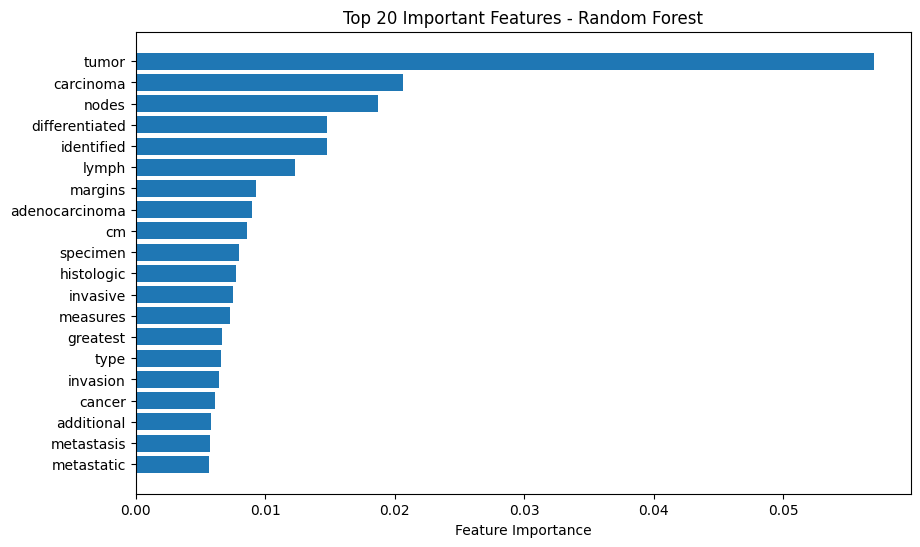


TOTAL NUMBER OF FEATURES: 37756

Top 20 Important Features: 
tumor
carcinoma
nodes
differentiated
identified
lymph
margins
adenocarcinoma
cm
specimen
histologic
invasive
measures
greatest
type
invasion
cancer
additional
metastasis
metastatic


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained Random Forest model
importances = best_rf.feature_importances_

# Get the feature names (terms) from the TF-IDF vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot the top 20 important features
plt.figure(figsize=(10, 6))
plt.title("Top 20 Important Features - Random Forest")
plt.barh(range(20), importances[indices[:20]], align="center")
plt.yticks(range(20), feature_names[indices[:20]])
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel("Feature Importance")
plt.show()

print("\nTOTAL NUMBER OF FEATURES:",len(feature_names))
# Display the most important features
top_features = feature_names[indices[:20]]
print("\nTop 20 Important Features: ")
for feature in top_features:
    print(feature)
    

#print("All Important Features:")
#for i in range(len(feature_names)):
    #print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")'''

In [65]:
print("7TH APRIL 2025\n\nAnalysing Dataset for clarity....\n\n")
# Basic info
print("Shape of dataset:", df.shape)
print("\nColumn types:")
print(df.dtypes)

# Peek at data
df.head()

print("\n\nMissing Values")
print(df.isnull().sum())

7TH APRIL 2025

Analysing Dataset for clarity....


Shape of dataset: (9505, 4)

Column types:
patient_filename    object
text                object
binary_label        object
multiclass_label    object
dtype: object


Missing Values
patient_filename    0
text                0
binary_label        0
multiclass_label    0
dtype: int64


Index(['patient_filename', 'text', 'binary_label', 'multiclass_label'], dtype='object')

Binary Label Distribution
binary_label
Cancer        9327
Non-Cancer     178
Name: count, dtype: int64


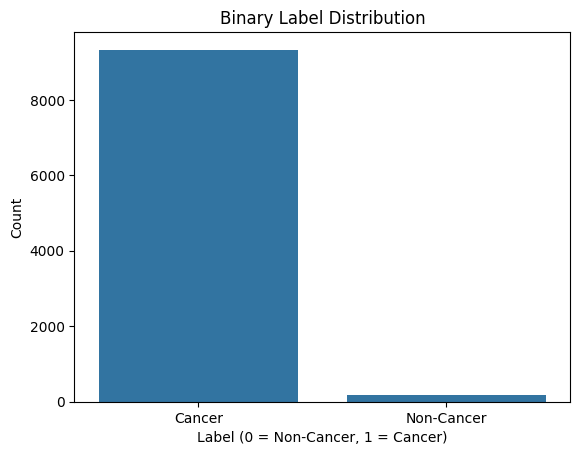


Multiclass Label Distribution
multiclass_label
Cancer           8470
Other             506
Normal            448
Benign             80
Pre-cancerous       1
Name: count, dtype: int64


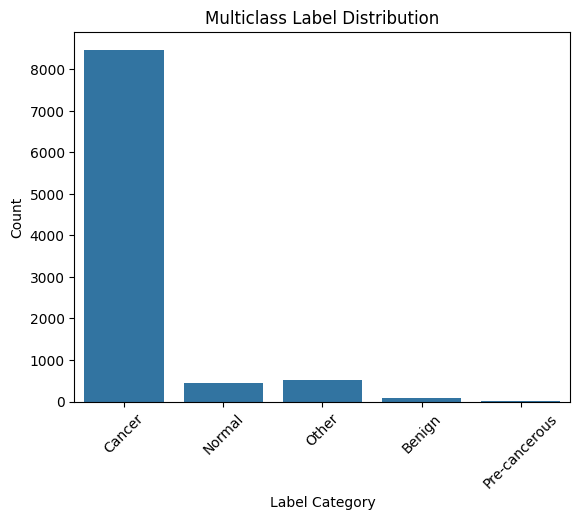

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df.columns)

# Distribution plot
print("\nBinary Label Distribution")
print(df['binary_label'].value_counts())
sns.countplot(x='binary_label', data=df)
plt.title("Binary Label Distribution")
plt.xlabel("Label (0 = Non-Cancer, 1 = Cancer)")
plt.ylabel("Count")
plt.show()

print("\nMulticlass Label Distribution")
print(df['multiclass_label'].value_counts())
sns.countplot(x='multiclass_label', data=df)
plt.title("Multiclass Label Distribution")
plt.xlabel("Label Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


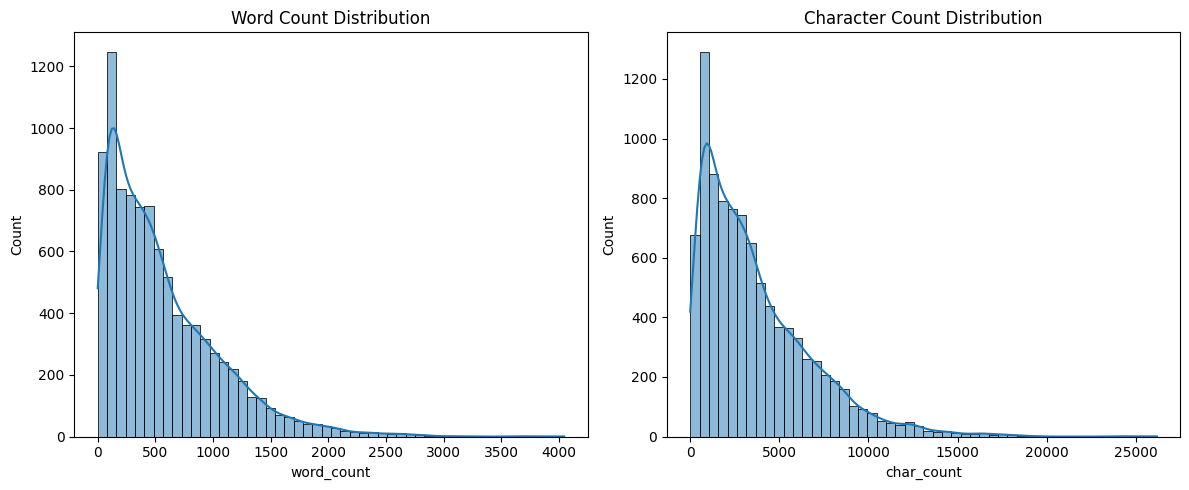

Average word count: 560.9814834297738
Average char count: 3671.8004208311413


In [67]:
# Word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Word Count Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['char_count'], bins=50, kde=True)
plt.title("Character Count Distribution")

plt.tight_layout()
plt.show()

# Mean/Median
print("Average word count:", df['word_count'].mean())
print("Average char count:", df['char_count'].mean())


Cancer/Non-Cancer text check 




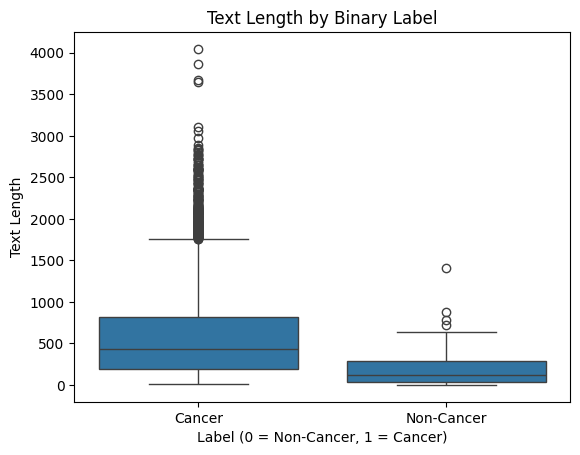

In [68]:
print("Cancer/Non-Cancer text check \n\n")
sns.boxplot(x='binary_label', y='word_count', data=df)
plt.title("Text Length by Binary Label")
plt.xlabel("Label (0 = Non-Cancer, 1 = Cancer)")
plt.ylabel("Text Length")
plt.show()

In [69]:
print("Convert Labels to Numeric\n\n")

# Convert binary_label to 0/1
df['binary_label'] = df['binary_label'].map({'Cancer': 1, 'Non-Cancer': 0})

# Optional: Convert multiclass_label to category if needed
df['multiclass_label'] = df['multiclass_label'].astype('category')

Convert Labels to Numeric




In [70]:
from collections import Counter

def get_top_words(df, label_val, label_col='binary_label', n=20):
    # Convert the text to lowercase and split into words
    texts = df[df[label_col] == label_val]['text'].str.lower().str.split()
    
    # Flatten the list of words and count the occurrences
    all_words = [word for tokens in texts for word in tokens]
    
    # Return the most common words
    return Counter(all_words).most_common(n)

# Top 20 words in Cancer class (1)
print("\nTop 20 words in Cancer class (1):")
print(get_top_words(df, 1))

# Top 20 words in Non-Cancer class (0)
print("\nTop 20 words in Non-Cancer class (0):")
print(get_top_words(df, 0))



Top 20 words in Cancer class (1):
[('the', 177560), ('of', 135448), ('and', 113868), ('is', 97723), ('x', 84843), ('lymph', 79571), ('in', 78623), ('a', 54262), ('-', 52887), ('tumor', 52864), ('cm', 50551), ('with', 50013), ('to', 45547), ('right', 35559), ('for', 34322), ('specimen', 34190), ('are', 33210), ('left', 32448), ('cm.', 30291), ('tissue', 28538)]

Top 20 words in Non-Cancer class (0):
[('the', 1277), ('of', 880), ('and', 694), ('is', 564), ('in', 490), ('a', 447), ('with', 329), ('x', 325), ('tumour', 311), ('for', 247), ('are', 235), ('to', 232), ('the.', 201), ('clinical', 195), ('no.', 156), ('report.', 148), ('left', 144), ('on', 140), ('tissue', 139), ('was', 139)]


In [71]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_words(df, label_val, label_col='binary_label', n=30):
    # Filter out stopwords
    texts = df[df[label_col] == label_val]['text'].str.lower().str.split()
    all_words = [word for tokens in texts for word in tokens if word not in stop_words]
    return Counter(all_words).most_common(n)

print("REMOVING STOP WORDS...")
# Top words for Cancer (1) class after removing stopwords
print("\nTop 30 words in Cancer class (1):")
print(get_top_words(df, 1))

# Top words for Non-Cancer (0) class after removing stopwords
print("\nTop 30 words in Non-Cancer class (0):")
print(get_top_words(df, 0))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Medha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


REMOVING STOP WORDS...

Top 30 words in Cancer class (1):
[('x', 84843), ('lymph', 79571), ('-', 52887), ('tumor', 52864), ('cm', 50551), ('right', 35559), ('specimen', 34190), ('left', 32448), ('cm.', 30291), ('tissue', 28538), ('nodes', 22317), ('submitted', 22235), ('1.', 22232), ('node', 22159), ('received', 20635), ('labeled', 20169), ('one', 16857), ('the.', 16805), ('section', 15744), ('measuring', 15219), ('a.', 15194), ('negative', 14055), ('identified.', 13763), ('margin', 13736), ('tumor.', 13734), ('carcinoma', 13559), ('sections', 13485), ('frozen', 12607), ('soft', 12120), ('part', 11529)]

Top 30 words in Non-Cancer class (0):
[('x', 325), ('tumour', 311), ('the.', 201), ('clinical', 195), ('no.', 156), ('report.', 148), ('left', 144), ('tissue', 139), ('right', 138), ('of.', 125), ('-', 124), ('cells', 123), ('frontal', 115), ('mass', 113), ('specimen', 111), ('adrenal', 109), ('sections', 108), ('grade', 106), ('cm', 106), ('melanoma', 106), ('diagnosis:', 102), ('brai

In [72]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

print("REMOVING STOP WORDS AND EXTRACTING COMMON WORDS IN CANCER AND NON-CANCER CLASSES\n\n")
# Download stopwords if not already downloaded
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_words(df, label_val, label_col='binary_label', n=50):
    # Filter out stopwords
    texts = df[df[label_col] == label_val]['text'].str.lower().str.split()
    all_words = [word for tokens in texts for word in tokens if word not in stop_words]
    return Counter(all_words).most_common(n)

# Get the top 20 words in Cancer (1) class
cancer_top_words = get_top_words(df, 1)

# Get the top 20 words in Non-Cancer (0) class
non_cancer_top_words = get_top_words(df, 0)

# Extract only the words from the top word counts (ignoring counts)
cancer_words = set([word for word, count in cancer_top_words])
non_cancer_words = set([word for word, count in non_cancer_top_words])

# Find common words between the two classes
common_words = cancer_words.intersection(non_cancer_words)

# Output the common words
print("Common words between Cancer and Non-Cancer classes:")
print(common_words)

# Find non-common words in both classes
cancer_unique = cancer_words - non_cancer_words
non_cancer_unique = non_cancer_words - cancer_words

print("\nNon-common words in Cancer class (1):")
print(cancer_unique)

print("\nNon-common words in Non-Cancer class (0):")
print(non_cancer_unique)


REMOVING STOP WORDS AND EXTRACTING COMMON WORDS IN CANCER AND NON-CANCER CLASSES


Common words between Cancer and Non-Cancer classes:
{'left', 'x', '-', 'received', 'a.', 'right', 'mass', 'submitted', 'tissue', '1.', 'the.', 'specimen', 'diagnosis:', 'cm', 'clinical', 'sections'}

Non-common words in Cancer class (1):
{'node', 'margin.', 'part', '2.', 'carcinoma', 'identified.', 'soft', 'and.', 'cm.', 'nodes,', 'frozen', 'section', 'labeled', 'anterior', 'measuring', 'margin', 'level', 'carcinoma.', 'tumor.', 'node,', ':', 'tumor', 'nodes', 'consists', '1', 'gross', 'measures', 'one', 'lymph', '2', 'posterior', 'representative', 'negative', 'tissue.'}

Non-common words in Non-Cancer class (0):
{'adrenal', 'cell', 'high', 'melanoma.', 'using', 'chromosome', 'cells', 'molecular', '2=', 'type.', 'performed', 'lab', 'histopathology', 'large', 'of.', 'tumour', 'choroidal', 'frontal', 'location.', 'description:', 'is.', 'grade', 'brain', 'consultant', '&', 'optic', 'no.', 'dna', 'report.', 

In [73]:
# Filter cancer class rows
print("DETECTED IMBALANCE IN CLASS DISTRIBUTION\n")
print("FINDING FAULTS IN CLASSIFICATION OF CANCER CLASS")
print(df['binary_label'].unique())
cancer_texts = df[df['binary_label'] == 1]['text'].str.lower()

# Count how many times "no" and "non" appear across all cancer texts
no_count = cancer_texts.str.count(r'\bno\b').sum()
non_count = cancer_texts.str.count(r'\bnon\b').sum()

print(f'Frequency of the word "no" in Cancer class: {no_count}')
print(f'Frequency of the word "non" in Cancer class: {non_count}')

text = cancer_texts[cancer_texts.str.contains(r'\bno\b', regex=True)].sample(1).tolist()[0]

text_lower = text.lower()

# Find indices of 'no' and 'non' as whole words
no_matches = [m.start() for m in re.finditer(r'\bno\b', text_lower)]
non_matches = [m.start() for m in re.finditer(r'\bnon\b', text_lower)]

# Print results with context
print("Occurrences of 'no':")
for idx in no_matches:
    print(f"Index {idx}: '{text_lower[idx-20:idx+20]}'")

print("\nOccurrences of 'non':")
for idx in non_matches:
    print(f"Index {idx}: '{text_lower[idx:idx+10]}'")


DETECTED IMBALANCE IN CLASS DISTRIBUTION

FINDING FAULTS IN CLASSIFICATION OF CANCER CLASS
[1 0]
Frequency of the word "no" in Cancer class: 29881
Frequency of the word "non" in Cancer class: 3390
Occurrences of 'no':
Index 551: 'dentified. there is no evidence of necro'
Index 1694: 'nd scant cytoplasm. no necrosis or endot'

Occurrences of 'non':


In [74]:
# Filter cancer class rows
print("DETECTED IMBALANCE IN CLASS DISTRIBUTION\n")
print("FINDING FAULTS IN CLASSIFICATION OF NON-CANCER CLASS")
print(df['binary_label'].unique())
cancer_texts = df[df['binary_label'] == 0]['text'].str.lower()

# Count how many times "no" and "non" appear across all cancer texts
no_count = cancer_texts.str.count(r'\bno\b').sum()
non_count = cancer_texts.str.count(r'\bnon\b').sum()

print(f'Frequency of the word "no" in Cancer class: {no_count}')
print(f'Frequency of the word "non" in Cancer class: {non_count}')

text = cancer_texts[cancer_texts.str.contains(r'\bno\b', regex=True)].sample(1).tolist()[0]

text_lower = text.lower()

# Find indices of 'no' and 'non' as whole words
no_matches = [m.start() for m in re.finditer(r'\bno\b', text_lower)]
non_matches = [m.start() for m in re.finditer(r'\bnon\b', text_lower)]

# Print results with context
print("Occurrences of 'no':")
for idx in no_matches:
    print(f"Index {idx}: '{text_lower[idx-20:idx+20]}'")

print("\nOccurrences of 'non':")
for idx in non_matches:
    print(f"Index {idx}: '{text_lower[idx:idx+10]}'")


DETECTED IMBALANCE IN CLASS DISTRIBUTION

FINDING FAULTS IN CLASSIFICATION OF NON-CANCER CLASS
[1 0]
Frequency of the word "no" in Cancer class: 329
Frequency of the word "non" in Cancer class: 16
Occurrences of 'no':
Index 30: 'logy report. biopsy no: received date/ti'
Index 498: ' x 0.6cm. (al & a2; no reserve). microsc'
Index 1061: 'n of mum1. there is no expression of cd3'
Index 1287: 'shwork and there is no overexpression of'

Occurrences of 'non':
Index 230: 'non-germin'


In [75]:
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_resampled)/sum(y_train_resampled == "Non-Cancer"), 
                          n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate Performance
print("\nXGBoost Model Performance:\n")
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Cancer' 'Non-Cancer']